# Clothing Image  Classification 

In [0]:
!pip install -U tensorflow_datasets

Requirement already up-to-date: tensorflow_datasets in /usr/local/lib/python3.6/dist-packages (1.0.2)


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals


# Import TensorFlow and TensorFlow Datasets
import tensorflow as tf
import tensorflow_datasets as tfds
tf.logging.set_verbosity(tf.logging.ERROR)

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

# Improve progress bar display
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm


print(tf.__version__)

# This will go away in the future.
# If this gives an error, you might be running TensorFlow 2 or above
# If so, then just comment out this line and run this cell again
tf.enable_eager_execution()  


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

1.13.1


## Importing the data 

The Fashion MNIST dataset contains 70,000 grayscale images in 10 clothing categories.  

In [0]:
# load the dataset from the TF library and split into test and train subsets
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [0]:
# a list to house the more human readable labels for the clothing categories
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

## Exploring the Data

In [0]:
# looking at the train/test split
num_train = metadata.splits['train'].num_examples
num_test = metadata.splits['test'].num_examples

print("Number of training examples: {}".format(num_train))
print("Number of test examples:     {}".format(num_test))

Number of training examples: 60000
Number of test examples:     10000


## Preprocessing the Data

In [0]:
def normalize(images, labels):
  '''
  Normalizes the images to a range between 0-1
  '''
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

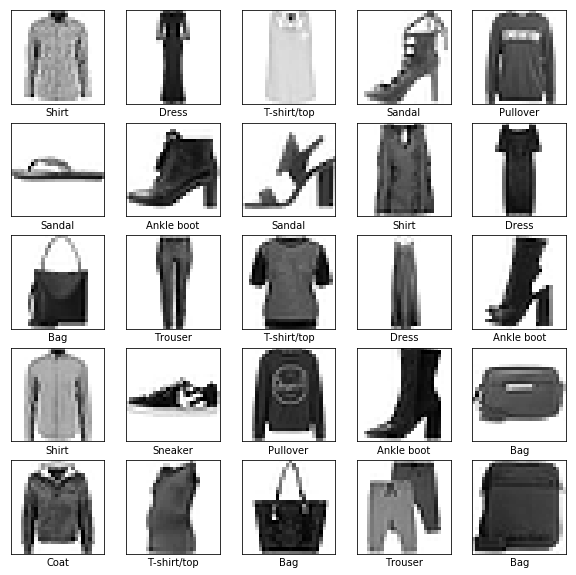

In [0]:
# Visualizing the model
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

## Model Building
### Layer Setup
1. Flattening layer to convert from 2d array to 1d array
2. Hidden dense layer utilizing ReLU
3. Output dense layer utilzing softmax

In [0]:
# Setting up the model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

### Compiling the Model
1. Loss function 
2. Optimizer
3. Metrics

In [0]:
# Compiling the model
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

## Model Training


Define the iteration behavior for the train dataset:
1. Repeat forever by specifying `dataset.repeat()` (the `epochs` parameter described below limits how long we perform training).
2. The `dataset.shuffle(60000)` randomizes the order so our model cannot learn anything from the order of the examples.
3. And `dataset.batch(32)` tells `model.fit` to use batches of 32 images and labels when updating the model variables.

Training is performed by calling the `model.fit` method:
1. Feed the training data to the model using `train_dataset`.
2. The model learns to associate images and labels.
3. The `epochs=5` parameter limits training to 5 full iterations of the training dataset, so a total of 5 * 60000 = 300000 examples.

In [0]:
# training the model
BATCH_SIZE = 32

train_dataset = train_dataset.repeat().shuffle(num_train).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 24s 13ms/step - loss: 0.4963 - acc: 0.8259
Epoch 2/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.3769 - acc: 0.8648
Epoch 3/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3376 - acc: 0.8775
Epoch 4/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.3115 - acc: 0.8863
Epoch 5/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.2991 - acc: 0.8908


## Evaluate Accuracy 
### Using the Validation Set

In [0]:
# Evaluating the accuracy of the model
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 2s 7ms/step - loss: 0.3596 - acc: 0.8685
Accuracy on test dataset: 0.8685


## Make Predictions 

In [0]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)
  
np.argmax(predictions[0])

6

In [0]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

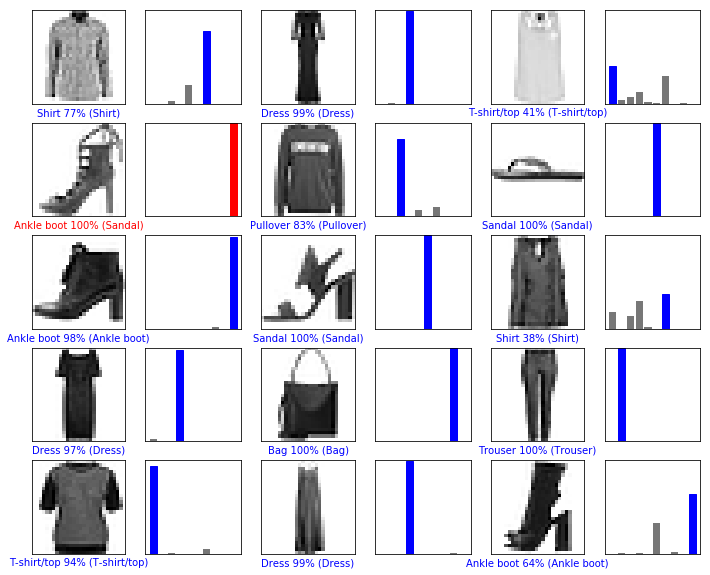

In [0]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

## Model Tuning

1. Changing the epochs from 5 to 1

In [0]:
# Setting up the model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

print("Built the model...")

# Compiling the model
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

print("Compiled the model...")
# training the model
BATCH_SIZE = 32

train_dataset = train_dataset.repeat().shuffle(num_train).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

model.fit(train_dataset, epochs=1, steps_per_epoch=math.ceil(num_train/BATCH_SIZE))
print("Fit the model...")
# Evaluating the accuracy of the model
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test/32))
print('Accuracy on test dataset:', test_accuracy)

Built the model...
Compiled the model...
Epoch 1/5


### Varying Batch Size, Layers, and Nodes

In [0]:
# Setting up the model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(24, activation=tf.nn.relu),
    tf.keras.layers.Dense(24, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

print("Built the model...")

# Compiling the model
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

print("Compiled the model...")
# training the model
BATCH_SIZE = 32

train_dataset = train_dataset.repeat().shuffle(num_train).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train/BATCH_SIZE))
print("Fit the model...")
# Evaluating the accuracy of the model
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test/32))
print('Accuracy on test dataset:', test_accuracy)

Built the model...
Compiled the model...
Epoch 1/5
1875/1875 [==============================] - 24s 13ms/step - loss: 0.5874 - acc: 0.7982
Epoch 2/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.4190 - acc: 0.8528
Epoch 3/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3866 - acc: 0.8608
Epoch 4/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3604 - acc: 0.8701
Epoch 5/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.3558 - acc: 0.8716
Fit the model...
313/313 [==============================] - 2s 7ms/step - loss: 0.3874 - acc: 0.8639
Accuracy on test dataset: 0.8639


In [0]:
# Setting up the model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(24, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

print("Built the model...")

# Compiling the model
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

print("Compiled the model...")
# training the model
BATCH_SIZE = 20

train_dataset = train_dataset.repeat().shuffle(num_train).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train/BATCH_SIZE))
print("Fit the model...")
# Evaluating the accuracy of the model
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test/32))
print('Accuracy on test dataset:', test_accuracy)

Built the model...
Compiled the model...
Epoch 1/5
3000/3000 [==============================] - 29s 10ms/step - loss: 0.5023 - acc: 0.8202
Epoch 2/5
3000/3000 [==============================] - 20s 7ms/step - loss: 0.3707 - acc: 0.8664
Epoch 3/5
3000/3000 [==============================] - 19s 6ms/step - loss: 0.3331 - acc: 0.8769
Epoch 4/5
3000/3000 [==============================] - 19s 6ms/step - loss: 0.3133 - acc: 0.8844
Epoch 5/5
3000/3000 [==============================] - 19s 6ms/step - loss: 0.2917 - acc: 0.8907
Fit the model...
313/313 [==============================] - 2s 5ms/step - loss: 0.3753 - acc: 0.8657
Accuracy on test dataset: 0.86565495
